## Setup 
This is originally on Google Colab.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

# Direct to your assignment folder.
%cd /content/drive/MyDrive/ML_P2_Illustrations

%load_ext autoreload
%autoreload 1


Mounted at /content/drive
/content/drive/MyDrive/ML_P2_Illustrations


In [ ]:
pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.5 MB/s eta 0:00:00


## BERTScore Evaluation

We read the CSV files containing zero-shot and chain-of-thought outputs, parses their results into a standardized 5-point structure (Setting, Entities, Actions, Interactions, Emotional Tone), computes the BERTScore similarity between the zero-shot and chain-of-thought outputs for each category, and finally produces both a CSV file of results and a box plot visualization of the distributions of these BERTScore values.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

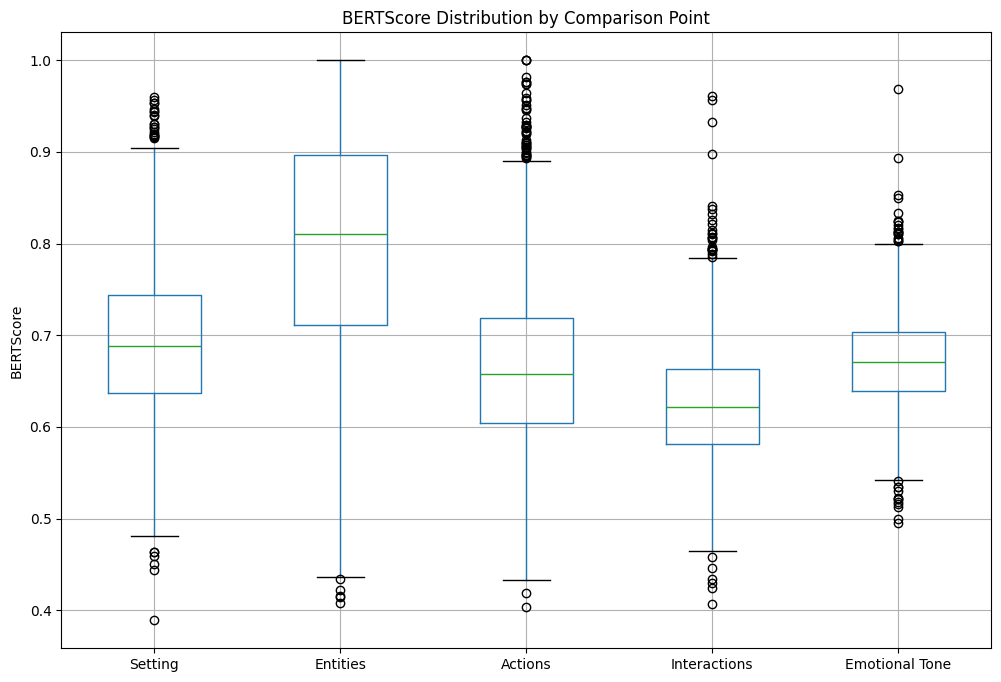

In [ ]:
import pandas as pd
import re
from bert_score import score
import matplotlib.pyplot as plt
import torch

# Function to extract the bullet points (5-point structure)
def extract_bullet_points(text):
    # Pattern for detecting bullet points like "1. ...", "- ...", etc.
    bullet_pattern = re.compile(r"(?:^|\n)(\d+\.|[-*])\s*(.+?)(?=(\n\d+\.|\n[-*]|\n*$))", re.DOTALL)
    matches = bullet_pattern.findall(text)
    return [match[1].strip() for match in matches] if len(matches) == 5 else None

# Function to extract structured chain_of_thought content
def extract_chain_of_thought(text):
    chain_pattern = re.compile(
        r"Setting:\s*(.*?)\nEntities:\s*(.*?)\nActions:\s*(.*?)\nInteractions:\s*(.*?)\nEmotional Tone:\s*(.*?)(?=$|\n)",
        re.DOTALL
    )
    match = chain_pattern.search(text)
    if match:
        return [match.group(i).strip() for i in range(1, 6)]
    return None

# Function to split zero_shot and chain_of_thought into new columns
def split_columns(df):
    for idx, row in df.iterrows():
        zero_shot_points = extract_bullet_points(row['zero_shot'])
        chain_of_thought_points = extract_chain_of_thought(row['chain_of_thought'])

        # Assign extracted bullet points into new columns
        if zero_shot_points:
            df.at[idx, 'zero_shot_Setting'] = zero_shot_points[0]
            df.at[idx, 'zero_shot_Entities'] = zero_shot_points[1]
            df.at[idx, 'zero_shot_Actions'] = zero_shot_points[2]
            df.at[idx, 'zero_shot_Interactions'] = zero_shot_points[3]
            df.at[idx, 'zero_shot_Emotional_Tone'] = zero_shot_points[4]

        if chain_of_thought_points:
            df.at[idx, 'chain_of_thought_Setting'] = chain_of_thought_points[0]
            df.at[idx, 'chain_of_thought_Entities'] = chain_of_thought_points[1]
            df.at[idx, 'chain_of_thought_Actions'] = chain_of_thought_points[2]
            df.at[idx, 'chain_of_thought_Interactions'] = chain_of_thought_points[3]
            df.at[idx, 'chain_of_thought_Emotional_Tone'] = chain_of_thought_points[4]

    return df

# Function to calculate BERTScore
def calculate_bertscore(refs, preds, model_type='bert-base-uncased', batch_size=128):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    P, R, F1 = score(preds, refs, lang='en', model_type=model_type, device=device, batch_size=batch_size, verbose=False)
    return [f.item() for f in F1]

# Main comparison function
def compare_5_point_columns(df):
    results = []
    exceptions = []

    # Filter rows where all 10 columns are non-NaN
    required_columns = [
        'zero_shot_Setting', 'zero_shot_Entities', 'zero_shot_Actions', 'zero_shot_Interactions', 'zero_shot_Emotional_Tone',
        'chain_of_thought_Setting', 'chain_of_thought_Entities', 'chain_of_thought_Actions', 'chain_of_thought_Interactions', 'chain_of_thought_Emotional_Tone'
    ]
    filtered_df = df.dropna(subset=required_columns)

    for idx, row in filtered_df.iterrows():
        refs = [
            row['zero_shot_Setting'],
            row['zero_shot_Entities'],
            row['zero_shot_Actions'],
            row['zero_shot_Interactions'],
            row['zero_shot_Emotional_Tone']
        ]
        preds = [
            row['chain_of_thought_Setting'],
            row['chain_of_thought_Entities'],
            row['chain_of_thought_Actions'],
            row['chain_of_thought_Interactions'],
            row['chain_of_thought_Emotional_Tone']
        ]

        try:
            bertscores = calculate_bertscore(refs, preds)
            results.append({
                'row': idx,
                'BERTScore_Setting': bertscores[0],
                'BERTScore_Entities': bertscores[1],
                'BERTScore_Actions': bertscores[2],
                'BERTScore_Interactions': bertscores[3],
                'BERTScore_Emotional_Tone': bertscores[4]
            })
        except Exception as e:
            exceptions.append({'row': idx, 'reason': f'BERTScore computation error: {str(e)}'})

    return pd.DataFrame(results), pd.DataFrame(exceptions)

# Function to plot BERTScore distributions as box plots
def plot_bertscore_boxplots(results):
    scores = results[['BERTScore_Setting', 'BERTScore_Entities', 'BERTScore_Actions',
                      'BERTScore_Interactions', 'BERTScore_Emotional_Tone']]
    plt.figure(figsize=(12, 8))
    scores.boxplot()
    plt.title('BERTScore Distribution by Comparison Point')
    plt.ylabel('BERTScore')
    plt.xticks([1, 2, 3, 4, 5], ['Setting', 'Entities', 'Actions', 'Interactions', 'Emotional Tone'])
    plt.grid(True)
    plt.show()

# Load the data
df1 = pd.read_csv("out_fold1.csv")
df2 = pd.read_csv("out_fold2.csv")
df3 = pd.read_csv("out_fold3.csv")

# Concat three folds
df = pd.concat([df1, df2, df3], ignore_index=True)

# Split the outputs into 5 categories each
df = split_columns(df)

# Compare each category and compute BERTScore
results, exceptions = compare_5_point_columns(df)
results.to_csv("bertscore_results.csv", index=False)

# Visualization
plot_bertscore_boxplots(results)
